In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [2]:
root = r"Images histopathologies"

total_count = 0
class_0_count = 0
class_1_count = 0

for patient_id in os.listdir(root):
    patient_path = os.path.join(root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    
    for class_label in ["0", "1"]:
        class_path = os.path.join(patient_path, class_label)
        if not os.path.isdir(class_path):
            continue
        
        count = len([f for f in os.listdir(class_path)
                     if f.endswith(".png")])

        total_count += count

        if class_label == "0":
            class_0_count += count
        else:
            class_1_count += count

print("Total images:", total_count)
print("Class 0 (non-IDC):", class_0_count)
print("Class 1 (IDC):", class_1_count)

Total images: 277524
Class 0 (non-IDC): 198738
Class 1 (IDC): 78786


In [3]:
rows = []

for patient_id in os.listdir(root):
    patient_path = os.path.join(root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    
    for label in ["0", "1"]:
        label_path = os.path.join(patient_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for fname in os.listdir(label_path):
            if fname.endswith(".png"):
                rows.append({
                    "patient_id": int(patient_id),
                    "label": int(label),
                    "filename": os.path.join(label_path, fname)
                })

df = pd.DataFrame(rows)
print(df.head())
print(df.shape)

   patient_id  label                                           filename
0       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
1       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
2       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
3       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
4       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
(277524, 3)


In [4]:
#datasets des id des patients
patients = df["patient_id"].unique()

train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_patients, test_size=0.1, random_state=42)

df_train_images = df[df["patient_id"].isin(train_patients)]
df_val_images = df[df["patient_id"].isin(val_patients)]
df_test_images = df[df["patient_id"].isin(test_patients)]

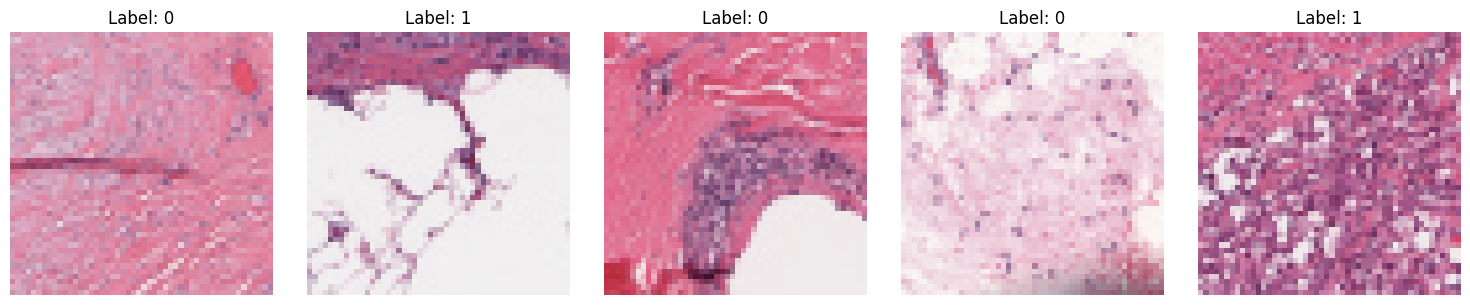

In [5]:
def echantillon_images(df, n=5):
    sample = df.sample(n)   # randomly pick n rows

    plt.figure(figsize=(15, 3))

    for i, (_, row) in enumerate(sample.iterrows()):
        img = Image.open(row["filename"])

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {row['label']}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

echantillon_images(df_train_images, n=5)

# Data preparation

In [6]:
#datasets des images
IMG_SIZE = 50 

#maps filename to actual image data
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)  # scales to [0,1]
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((df_train_images["filename"], df_train_images["label"]))
train_ds = train_ds.map(load_preprocess).shuffle(5000).batch(64).prefetch(1) #shuffle pour rendre les images aleatoires chaque epoch

val_ds = tf.data.Dataset.from_tensor_slices((df_val_images["filename"], df_val_images["label"]))
val_ds = val_ds.map(load_preprocess).batch(64).prefetch(1)

test_ds = tf.data.Dataset.from_tensor_slices((df_test_images["filename"], df_test_images["label"]))
test_ds = test_ds.map(load_preprocess).batch(64).prefetch(1)

In [7]:
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid') 
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 596s 195ms/step - accuracy: 0.8454 - loss: 0.4191 - val_accuracy: 0.8275 - val_loss: 0.3985
Epoch 2/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 613s 192ms/step - accuracy: 0.8641 - loss: 0.3211 - val_accuracy: 0.8119 - val_loss: 0.5001
Epoch 3/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 589s 193ms/step - accuracy: 0.8702 - loss: 0.3093 - val_accuracy: 0.8517 - val_loss: 0.3831
Epoch 4/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 589s 193ms/step - accuracy: 0.8727 - loss: 0.3029 - val_accuracy: 0.8476 - val_loss: 0.4245
Epoch 5/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 588s 193ms/step - accuracy: 0.8756 - loss: 0.2962 - val_accuracy: 0.8426 - val_loss: 0.3945
Epoch 6/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 619s 194ms/step - accuracy: 0.8767 - loss: 0.2917 - val_accuracy: 0.8531 - val_loss: 0.4458
Epoch 8/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 618s 192ms/step - accuracy: 0.8781 - loss: 0.2922 - val_accuracy: 0.8501 - val_loss: 0.4264
Epoch 9/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 620s 191ms/step - ac

# Evaluation

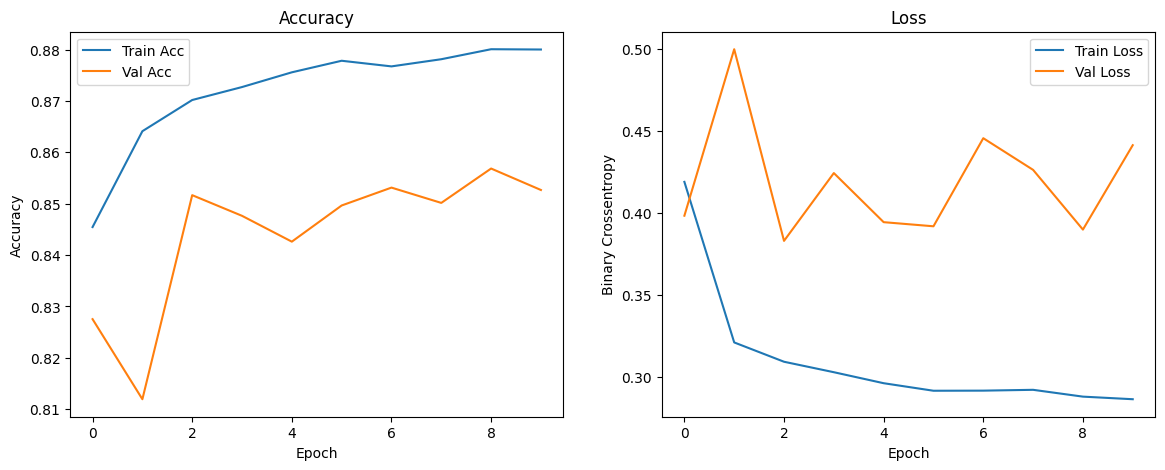

In [10]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

899/899 ━━━━━━━━━━━━━━━━━━━━ 155s 172ms/step - accuracy: 0.8569 - loss: 0.3918
Test Accuracy: 0.8569
Test Loss: 0.3918


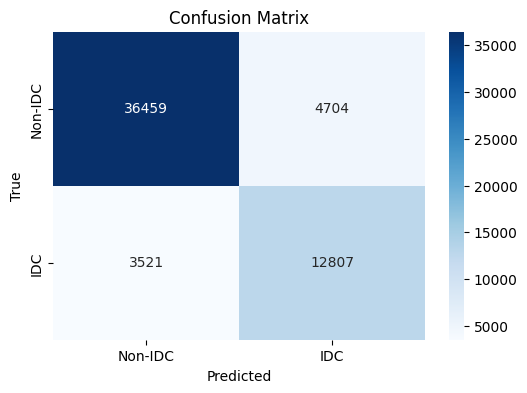

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     41163
           1       0.73      0.78      0.76     16328

    accuracy                           0.86     57491
   macro avg       0.82      0.84      0.83     57491
weighted avg       0.86      0.86      0.86     57491



In [16]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0).ravel()
    y_pred.extend((preds > 0.5).astype(int))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-IDC','IDC'],
            yticklabels=['Non-IDC','IDC'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred))

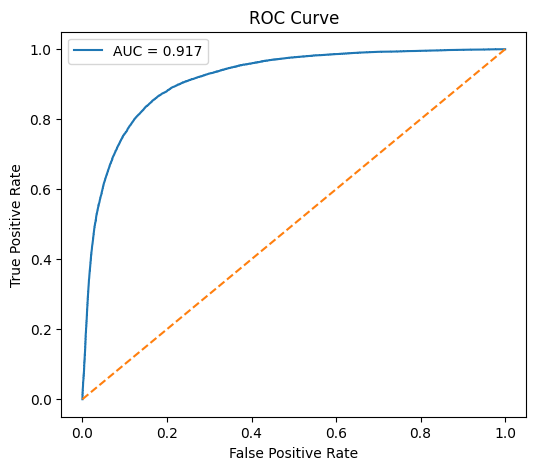

In [17]:
y_scores = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0).ravel()
    y_scores.extend(preds)

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [15]:
model.save("breast_cancer_image_cnn.keras")
print("Model saved!")

Model saved!
